# Setup

In [1]:
import time
import random

import torch
import torch.nn.functional as F
import torchtext

import numpy as np

from data_utils import format_time
from discriminator import Discriminator
from generator import Generator

In [2]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

In [3]:
print_each_n_step = 100
num_train_epochs = 50
noise_size = 100
batch_size = 8
epsilon = 1e-8

In [4]:

if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# Dataset

In [5]:
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []
with open('../ganbert_subj/data/subj/train_orig.txt', 'r') as f:
    for line in f:
        label, sentence = line.split('\t')
        train_sentences.append(sentence)
        train_labels.append(label)
with open('../ganbert_subj/data/subj/test.txt', 'r') as f:
    for line in f:
        label, sentence = line.split('\t')
        test_sentences.append(sentence)
        test_labels.append(label)

In [6]:
train_sentences[:2], train_labels[:2]

(['pirates of the caribbean is a sweeping action-adventure story set in an era when villainous pirates scavenged the caribbean seas . \n',
  'my 5-year-old niece emily was so thrilled by the first 20 minutes , she announced , " i\'m gonna try to stay awake through the whole movie ! " , which she then proceeded to do . \n'],
 ['1', '0'])

In [7]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [8]:
def yield_tokens(sentences):
    for sen in sentences:
        yield tokenizer(sen)

vocab = torchtext.vocab.build_vocab_from_iterator(yield_tokens(train_sentences), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

In [9]:
text_pipeline(train_sentences[0])

[3099,
 7,
 4,
 7865,
 11,
 5,
 3176,
 11100,
 51,
 176,
 10,
 19,
 763,
 44,
 5548,
 3099,
 19018,
 4,
 7865,
 5352,
 2]

In [10]:
seq_size = max([len(tokenizer(text)) for text in train_sentences])
seq_size

118

In [11]:
def create_dataset(setnences, labels):
    input_ids = []
    label_ids = []

    for (text, label) in zip(setnences, labels):
        label_ids.append(label_pipeline(label))
        processed_text = text_pipeline(text)
        processed_text = [vocab['<pad>']] * (seq_size - len(processed_text)) + processed_text
        input_ids.append(processed_text)
    input_ids = torch.tensor(input_ids, dtype=torch.int64)
    label_ids = torch.tensor(label_ids)
    print(label_ids.shape)
    print(input_ids.shape)
    return torch.utils.data.TensorDataset(input_ids, label_ids)

train_dataset = create_dataset(train_sentences, train_labels)
test_dataset = create_dataset(test_sentences, test_labels)

torch.Size([9000])
torch.Size([9000, 118])
torch.Size([1000])
torch.Size([1000, 118])


In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Models

In [13]:
generator = Generator(noise_size=len(vocab), output_size=len(vocab))
discriminator = Discriminator(input_size=seq_size, vocab_size=len(vocab), padding_idx=vocab['<pad>'])


In [14]:
noise = torch.zeros(batch_size, seq_size, len(vocab), device=device).uniform_(0, 1)
h0 = generator.initHidden(batch_size, device)
gen_rep, h1 = generator(noise, h0)
print(noise.shape)
print(gen_rep.shape)
print(h1.shape)
torch.argmax(gen_rep, dim=2).shape

torch.Size([8, 118, 21473])
torch.Size([8, 118, 21473])
torch.Size([1, 8, 64])


torch.Size([8, 118])

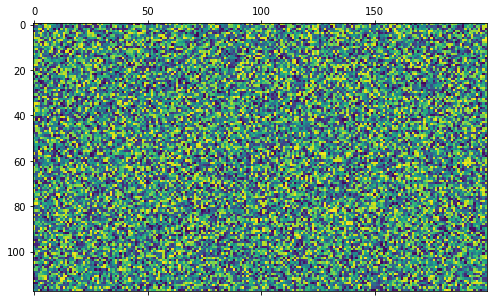

In [15]:
import matplotlib.pyplot as plt
import torch
noise = torch.zeros(118, 200).uniform_(0, 1)
plt.matshow(noise)
plt.savefig('img/noise.pdf')
plt.show()

In [16]:
x = torch.zeros(batch_size, seq_size, device=device, dtype=torch.int64)
_, _, probs = discriminator(x)
print(x.shape)
print(probs.shape)

torch.Size([8, 118])
torch.Size([8, 3])


In [17]:
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

In [18]:
training_stats = []
total_t0 = time.time()

In [19]:

g_vars = [v for v in generator.parameters()]
d_vars = [v for v in discriminator.parameters()]

gen_optimizer = torch.optim.AdamW(g_vars, lr=5e-5)
dis_optimizer = torch.optim.AdamW(d_vars, lr=5e-5)

In [20]:
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, (text, label) in enumerate(train_dataloader):
        # enumerate () method adds a counter to an iterable and returns it in a form of enumerate object.
        
        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        noise = torch.zeros(batch_size, seq_size, len(vocab), device=device).uniform_(0, 1)
        hidden = generator.initHidden(batch_size, device)
        gen_out, hidden = generator(noise, hidden)
        gen_rep = torch.argmax(gen_out, dim=2)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = torch.cat([text, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, batch_size)
        #Splits the tensor into chunks. Each chunk is a view of the original tensor
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
        
        logits_list = torch.split(logits, batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(label, 2)
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        # per_example_loss = torch.masked_select(per_example_loss, offset.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        
        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward(retain_graph=True)
        
        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()
        
        # A detail log of the individual losses
        # print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}". \
        #       format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U, \
        #              g_loss_d, g_feat_reg))
        
        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()
        
    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)  
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))

    print("Saving the models...............................")
    # Saving the model
    # torch.save(transformer, 'transformer')
    # torch.save(emergency_discriminator, 'emergency_discriminator')
    # torch.save(patient_discriminator, 'patient_discriminator')

        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    discriminator.eval()
    generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for text, label in test_dataloader:
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            _, logits, probs = discriminator(text)
            filtered_logits = logits[:,0:-1]
            total_test_loss += nll_loss(filtered_logits, label)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += label.detach().cpu()


    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()

    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )


======== Epoch 1 / 50 ========
Training...
  Batch   100  of  1,125.    Elapsed: 0:01:35.
  Batch   200  of  1,125.    Elapsed: 0:03:05.
  Batch   300  of  1,125.    Elapsed: 0:05:42.
  Batch   400  of  1,125.    Elapsed: 0:08:19.
  Batch   500  of  1,125.    Elapsed: 0:10:16.
  Batch   600  of  1,125.    Elapsed: 0:12:22.
  Batch   700  of  1,125.    Elapsed: 0:14:21.
  Batch   800  of  1,125.    Elapsed: 0:15:54.
  Batch   900  of  1,125.    Elapsed: 0:17:45.
  Batch 1,000  of  1,125.    Elapsed: 0:20:11.
  Batch 1,100  of  1,125.    Elapsed: 0:22:39.

  Average training loss generetor: 0.563
  Average training loss discriminator: 1.645
  Training epcoh took: 0:23:17
Saving the models...............................

Running Test...
  Accuracy: 0.743
  Test Loss: 0.565
  Test took: 0:00:00

======== Epoch 2 / 50 ========
Training...
  Batch   100  of  1,125.    Elapsed: 0:02:00.
  Batch   200  of  1,125.    Elapsed: 0:03:52.
  Batch   300  of  1,125.    Elapsed: 0:06:03.
  Batch   40

# Plotting Results

In [21]:
epochs = [stat['epoch'] for stat in training_stats]
train_loss_generator = [stat['Training Loss generator'] for stat in training_stats]
train_loss_discriminator = [stat['Training Loss discriminator'] for stat in training_stats]
valid_loss = [stat['Valid. Loss'] for stat in training_stats]
valid_acc = [stat['Valid. Accur.'] for stat in training_stats]

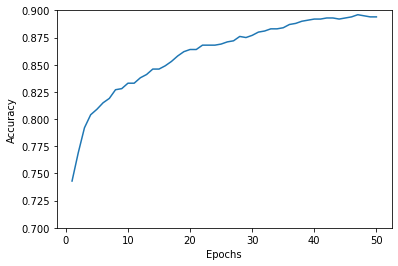

In [22]:
import matplotlib.pyplot as plt
plt.plot(epochs, valid_acc)
plt.ylim(0.7, 0.9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('img/accuracy.pdf')
plt.show()

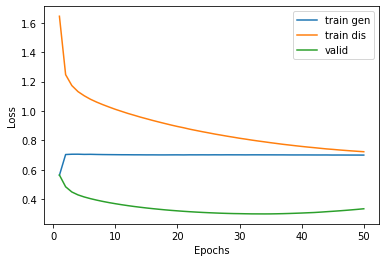

In [23]:
plt.plot(epochs, train_loss_generator)
plt.plot(epochs, train_loss_discriminator)
plt.plot(epochs, valid_loss)
plt.legend(['train gen', 'train dis', 'valid'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('img/loss.pdf')
plt.show()

In [24]:
noise = torch.zeros(batch_size, seq_size, len(vocab), device=device).uniform_(0, 1)
hidden = generator.initHidden(batch_size, device)
gen_out, hidden = generator(noise, hidden)
gen_rep = torch.argmax(gen_out, dim=2)
gen_rep.shape

torch.Size([8, 118])

In [25]:
gen_rep[0, :].numpy()

array([ 6870, 15442,   988, 17509, 13208,  8480, 15839, 14697, 15134,
         794,  9391, 11914,  3575,  2464,  4733, 18016, 18397, 17608,
       15569, 16431,  1518,   989, 19864,  3617,   464, 11730, 13851,
       17182, 11700,  1342,  7661, 10938,  5306, 14980,  7319,  7417,
       13390, 12416, 14025, 10593, 18372,  3020,  4812, 18144,  5471,
        8079,  6547, 19285,  1045,  2780, 20780, 14632,  3672,  2742,
        7035, 18171,  3494, 10333, 11304, 10597, 14648, 14605, 12293,
        1248,  9098,  1278, 10639,  8799,  1497, 15943, 12330, 10161,
       21013,  3248, 15843, 19418,  1562, 17113, 15001, 11399, 10217,
        1351, 13687,  7528,  7546, 20284,  9052,  9289, 17685,  8335,
       15811,   480, 20479, 19585, 16793, 13898,  3831,  7633,  5410,
        9474,  2067, 11789, 17595,  8723,  1925, 11314,  3697,  8907,
       10287, 11204, 19943, 15567,  8640,  7962, 12777,    62,  7083,
        9328])

In [26]:
vocab.lookup_tokens(gen_rep[1,:].numpy())

['quoted',
 'transformer',
 'addison',
 'alarm',
 'nitive',
 'p',
 'nikola',
 'archives',
 'football',
 'football',
 'brand',
 'shows',
 'secretary',
 'grimes',
 'ewan',
 'realized',
 'hardly',
 'bewildered',
 'zamindar',
 'decency',
 'clint',
 'conniving',
 'lasts',
 'spider-man',
 'decency',
 'banquet',
 'pros',
 'enact',
 'parable',
 'jewellery',
 'dimension',
 'miauczynski',
 'robbers',
 'schindler',
 'goodies',
 'olvidar',
 'helicopters',
 'jacobsen',
 'appealing',
 'carries',
 'hysterically',
 'collaborators',
 'austria',
 'tide-dyed',
 'delays',
 'utilization',
 'insect',
 'well-thought-out',
 'orchestra',
 'sci-fi',
 'belgium',
 'combines',
 'oak',
 'howard',
 'industry',
 'difference',
 'disrespectful',
 'justify',
 'rickman',
 'quit',
 'bleak',
 'banish',
 'auschwitz',
 'attack',
 'eliza',
 'mobius',
 'relocate',
 'action-thriller/dark',
 'austerity',
 'accuse',
 'slackers',
 'thankful',
 'valento',
 'jessie',
 'overseeing',
 'fed',
 'pop-influenced',
 '102-year-old',
 'reid'